In [7]:
import sys
sys.path.append('../../../')

In [8]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [9]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

In [10]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [11]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [12]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [13]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [14]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [01:05<00:00,  2.72s/it]


#### Results

In [15]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 394/394 [00:17<00:00, 23.00it/s]


In [16]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.2581043633336886,
 'epoch': 40,
 'train_loss': 0.7541814,
 'val_loss': 0.67641544,
 'train_acc': 0.3999999761581421,
 'val_acc': 0.4666665494441986,
 'val_rmse_perc': 0.2294699,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_40',
 'train_rmse': 1.0,
 'val_rmse': 0.9660917830792959,
 'test_rmse': 0.970299686427591,
 'train_mae': 0.7333333333333333,
 'val_mae': 0.6666666666666666,
 'test_mae': 0.6585185185185185,
 'train_mcc': 0.25246483906870976,
 'test_mcc': 0.31831948276464905,
 'tes

In [17]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37403179906912004,
 'epoch': 70,
 'train_loss': 0.71031934,
 'val_loss': 0.5434562,
 'train_acc': 0.36190474033355713,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.19244489,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_70',
 'train_rmse': 0.9154754164341269,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.9443790827055901,
 'train_mae': 0.7047619047619048,
 'val_mae': 0.5111111111111111,
 'test_mae': 0.674074074074074,
 'train_mcc': 0.23850726260162622,
 'test_mcc': 0.264727422176627,
 '

In [18]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.4062103742297434,
 'epoch': 30,
 'train_loss': 0.7900251,
 'val_loss': 0.6591515,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.21932301,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_30',
 'train_rmse': 0.9309493362512627,
 'val_rmse': 0.8819171036881969,
 'test_rmse': 0.8952549812659416,
 'train_mae': 0.7333333333333333,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6503703703703704,
 'train_mcc': 0.2635988651851568,
 'test_mcc': 0.328269095

In [19]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 394/394 [00:00<00:00, 23238.12it/s]


In [20]:
cm = all[sort_idx[0]]['test_cm'][0]

In [21]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

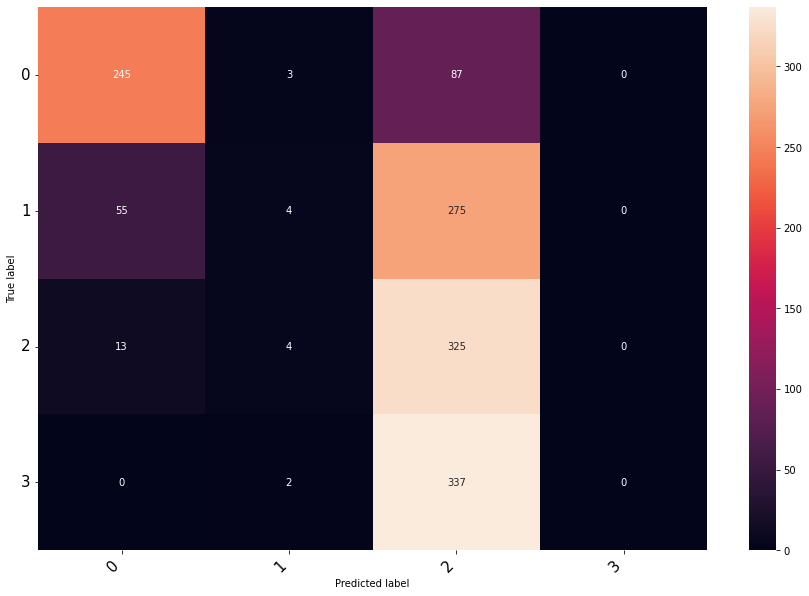

In [22]:
cm.visualize()

In [23]:
cm.class_accuracy

tensor([0.7313, 0.0120, 0.9503, 0.0000])

In [24]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.22770451, 0.25407845, 0.12376542, 0.2617987]

In [25]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.16797802, 0.23887245, 0.08461432, 0.25129825]

### GCN

In [26]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [27]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [06:40<00:00,  5.56s/it]


#### Results

In [28]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1187/1187 [01:09<00:00, 17.00it/s]


In [29]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3850403459219285,
 'epoch': 30,
 'train_loss': 0.851773,
 'val_loss': 0.5775064,
 'train_acc': 0.3142856955528259,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.2024156,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.56_4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_30',
 'train_rmse': 0.9807674351775563,
 'val_rmse': 0.8432740427115678,
 'test_rmse': 0.9132765594682007,
 'train_mae': 0.7714285714285715,
 'val_mae': 0.5333333333333333,
 'test_mae': 0.6414814814814814,
 'train_mcc': 0.190816884357585

In [30]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4881363189667353,
 'epoch': 22,
 'train_loss': 0.78973466,
 'val_loss': 0.5423934,
 'train_acc': 0.34285712242126465,
 'val_acc': 0.6222220659255981,
 'val_rmse_perc': 0.19109331,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.62_4_[10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0',
 'train_rmse': 0.9102589898327995,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.8777074514725111,
 'train_mae': 0.7142857142857143,
 'val_mae': 0.4666666666666667,
 'test_mae': 0.6385185185185185,
 'train_mcc': 0.2313987631946823,
 't

In [31]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.38184857209494616,
 'epoch': 90,
 'train_loss': 0.7618264,
 'val_loss': 0.56382746,
 'train_acc': 0.32380950450897217,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.20212576,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.56_4_[10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_90',
 'train_rmse': 0.9050124966251124,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.873053390247253,
 'train_mae': 0.7238095238095238,
 'val_mae': 0.5111111111111111,
 'test_mae': 0.6392592592592593,
 'train_mcc': 0.1930838910763206,


In [32]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1187/1187 [00:00<00:00, 21639.67it/s]


### GraphSAGE

In [33]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [34]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [1:15:07<00:00, 26.83s/it]


#### Results

In [35]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 2393/2393 [06:38<00:00,  6.00it/s]


True

In [36]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6428874427248503,
 'epoch': 80,
 'train_loss': 0.11017299,
 'val_loss': 0.25641683,
 'train_acc': 0.9333332777023315,
 'val_acc': 0.733333170413971,
 'val_rmse_perc': 0.15350774,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.73_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_80',
 'train_rmse': 0.3518657752744984,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.5912948753622254,
 'train_mae': 0.08571428571428572,
 'val_mae': 0.28888888888888886,
 'test_mae': 0.2903703703703704,


In [37]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5739037866390858,
 'epoch': 100,
 'train_loss': 0.35226387,
 'val_loss': 0.25082132,
 'train_acc': 0.7714285254478455,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.13116878,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.69_4_[15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2_100',
 'train_rmse': 0.5345224838248488,
 'val_rmse': 0.5577733510227171,
 'test_rmse': 0.6804138174397717,
 'train_mae': 0.24761904761904763,
 'val_mae': 0.3111111111111111,
 'test_mae': 0.38,
 'train_

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6428874427248503,
 'epoch': 80,
 'train_loss': 0.11017299,
 'val_loss': 0.25641683,
 'train_acc': 0.9333332777023315,
 'val_acc': 0.733333170413971,
 'val_rmse_perc': 0.15350774,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.73_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_80',
 'train_rmse': 0.3518657752744984,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.5912948753622254,
 'train_mae': 0.08571428571428572,
 'val_mae': 0.28888888888888886,
 'test_mae': 0.2903703703703704,


In [39]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2393/2393 [00:00<00:00, 24986.48it/s]


#### cm

In [40]:
cm = all[sort_idx[0]]['test_cm'][0]

In [41]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

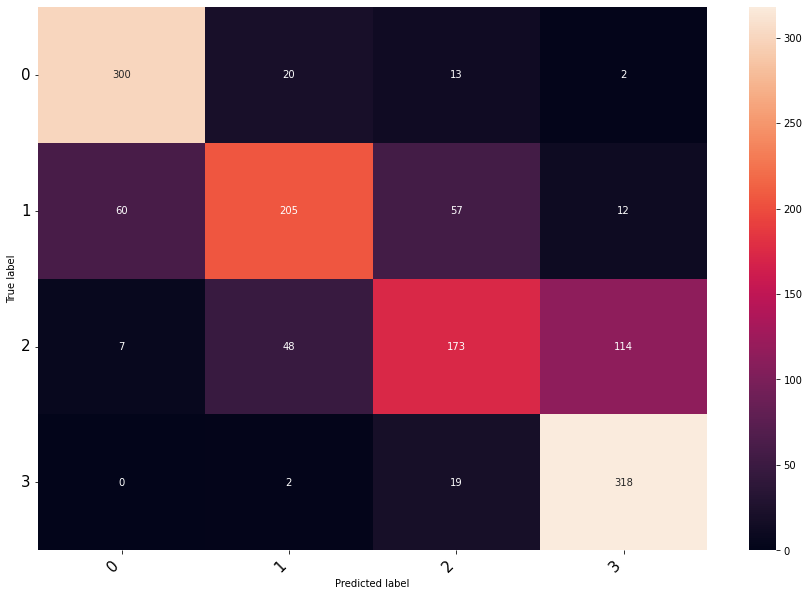

In [42]:
cm.visualize()

In [43]:
cm.class_accuracy

tensor([0.8955, 0.6138, 0.5058, 0.9381])

In [44]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.13748375, 0.15207481, 0.14557564, 0.08123048]

In [45]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08015282, 0.11047496, 0.115246944, 0.05718225]

#### GraphSAGE Base_n

In [46]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [47]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 336/336 [1:19:37<00:00, 14.22s/it]


##### Results

In [48]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

toast.show_toast("Done")

100%|██████████| 3790/3790 [06:04<00:00, 10.40it/s]


True

In [49]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3791568654211528,
 'epoch': 35,
 'train_loss': 0.12006019,
 'val_loss': 0.4100523,
 'train_acc': 0.5047618746757507,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.14076386,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.56_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.7037315505489968,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.7029040290637649,
 'train_mae': 0.49523809523809526,
 'val_mae': 0.4444444444444444,
 'test_mae': 0.4540740740740741,
 'train_mcc'

In [50]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3791568654211528,
 'epoch': 35,
 'train_loss': 0.12006019,
 'val_loss': 0.4100523,
 'train_acc': 0.5047618746757507,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.14076386,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.56_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.7037315505489968,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.7029040290637649,
 'train_mae': 0.49523809523809526,
 'val_mae': 0.4444444444444444,
 'test_mae': 0.4540740740740741,
 'train_mcc'

In [51]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3791568654211528,
 'epoch': 35,
 'train_loss': 0.12006019,
 'val_loss': 0.4100523,
 'train_acc': 0.5047618746757507,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.14076386,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.56_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.7037315505489968,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.7029040290637649,
 'train_mae': 0.49523809523809526,
 'val_mae': 0.4444444444444444,
 'test_mae': 0.4540740740740741,
 'train_mcc'

In [52]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3790/3790 [00:00<00:00, 23746.76it/s]


##### cm

In [53]:
cm = all[sort_idx[0]]['test_cm'][0]

In [54]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

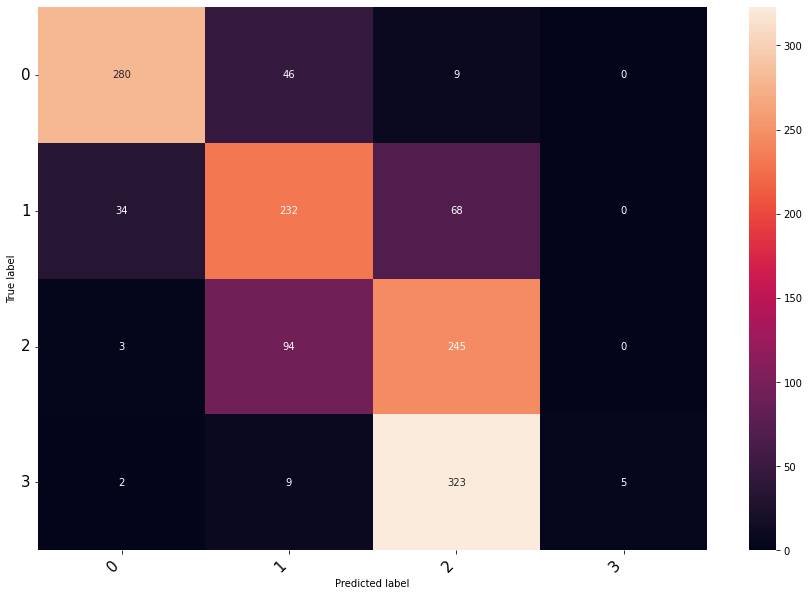

In [55]:
cm.visualize()

In [56]:
cm.class_accuracy

tensor([0.8358, 0.6946, 0.7164, 0.0147])

In [57]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10112021, 0.11326213, 0.12663509, 0.25338516]

In [58]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.06859846, 0.0916849, 0.10328449, 0.23868564]

#### GraphSAGE Scale

In [59]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [60]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 336/336 [1:22:06<00:00, 14.66s/it]


##### Results

In [61]:
res_edges_sage_scale = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

toast.show_toast("Done")

100%|██████████| 4448/4448 [08:23<00:00,  8.84it/s]


True

In [62]:
res_edges = res_edges_sage_scale
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4972918193064848,
 'epoch': 60,
 'train_loss': 0.3712245,
 'val_loss': 0.3704885,
 'train_acc': 0.6952380537986755,
 'val_acc': 0.6222220659255981,
 'val_rmse_perc': 0.15713134,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.62_4_[15]_1_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0_60',
 'train_rmse': 0.6248809410409238,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.6531972647421809,
 'train_mae': 0.3333333333333333,
 'val_mae': 0.4,
 'test_mae': 0.34814814814814815,
 'train_mcc': 0.5917107666515

In [63]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5846666999625596,
 'epoch': 90,
 'train_loss': 0.3415424,
 'val_loss': 0.273933,
 'train_acc': 0.714285671710968,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.13393092,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.69_4_[20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0_90',
 'train_rmse': 0.6546536707079771,
 'val_rmse': 0.6146362971528592,
 'test_rmse': 0.676592771006148,
 'train_mae': 0.3333333333333333,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.37777777777777777,
 'train_mcc': 0.6

In [64]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'mean',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.462330502275736,
 'epoch': 100,
 'train_loss': 0.2410826,
 'val_loss': 0.26876628,
 'train_acc': 0.7809523344039917,
 'val_acc': 0.5999998450279236,
 'val_rmse_perc': 0.15031233,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.60_4_[15_15]_1_mean_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0_100',
 'train_rmse': 0.4680252333449758,
 'val_rmse': 0.6831300510639732,
 'test_rmse': 0.6188400140286364,
 'train_mae': 0.21904761904761905,
 'val_mae': 0.4222222222222222,
 'test_mae': 0.3385185185185185,
 'train_m

In [65]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4448/4448 [00:00<00:00, 14437.68it/s]


##### cm

In [66]:
cm = all[sort_idx[0]]['test_cm'][0]

In [67]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

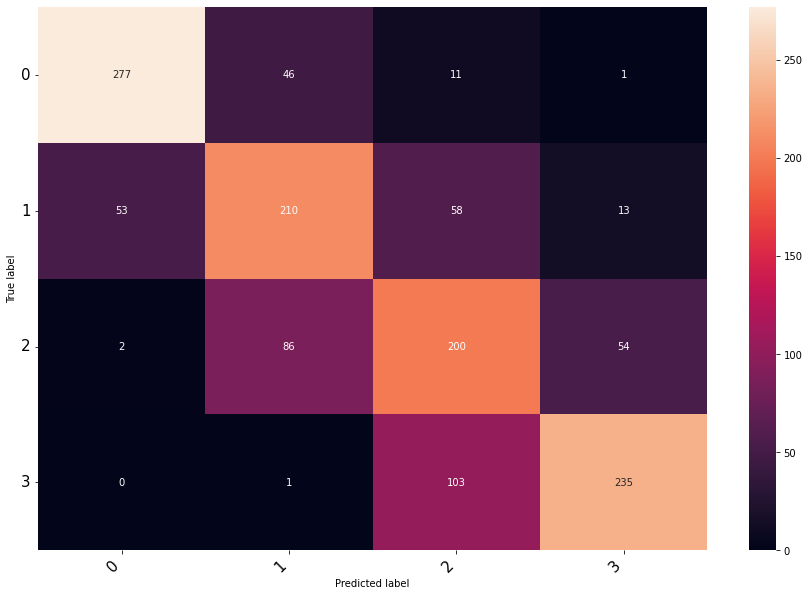

In [68]:
cm.visualize()

In [69]:
cm.class_accuracy

tensor([0.8269, 0.6287, 0.5848, 0.6932])

In [70]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.12996732, 0.1687171, 0.12937489, 0.114410274]

In [71]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.098527536, 0.120740674, 0.10657373, 0.08909751]

### GAT

In [72]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [73]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [54:06<00:00,  5.64s/it] 


#### Results

In [74]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 7645/7645 [06:12<00:00, 20.51it/s]


In [75]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': None,
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.42345190114951176,
 'epoch': 33,
 'train_loss': 1.5812933,
 'val_loss': 0.60297245,
 'train_acc': 0.45714282989501953,
 'val_acc': 0.577777624130249,
 'val_rmse_perc': 0.24032046,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.58_4_[25]_1_[4_4]_None_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2',
 'train_rmse': 1.0327955589886444,
 'val_rmse': 0.8299933065325822,
 'test_rmse': 0.9940564109486685,
 'train_mae': 0.7047619047619048,
 'val_mae': 0.5111111111111111,

In [76]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.36263285273285367,
 'epoch': 100,
 'train_loss': 0.6941498,
 'val_loss': 0.5584664,
 'train_acc': 0.40952378511428833,
 'val_acc': 0.5333331823348999,
 'val_rmse_perc': 0.17927502,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.53_4_[25]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0.2_100',
 'train_rmse': 0.8728715609439694,
 'val_rmse': 0.7302967433402214,
 'test_rmse': 0.8877770824639191,
 'train_mae': 0.6476190476190476,
 'val_mae': 0.488888888888

In [77]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.26072572903344343,
 'epoch': 70,
 'train_loss': 0.82778597,
 'val_loss': 0.5930628,
 'train_acc': 0.40952378511428833,
 'val_acc': 0.44444432854652405,
 'val_rmse_perc': 0.18244253,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.44_4_[25]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0.2_70',
 'train_rmse': 0.8728715609439694,
 'val_rmse': 0.8299933065325822,
 'test_rmse': 0.8923543557893895,
 'train_mae': 0.6476190476190476,
 'val_mae': 0.6,
 'test_ma

In [78]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 7645/7645 [00:00<00:00, 22300.09it/s]
